A vanilla ARIMA for TESLA using low, high, Close, Adj Close and Volume

---



**Import required libraries**

In [78]:
import pandas as pd
import numpy as np
from numpy import log
import io

import yfinance as yf
import requests

import matplotlib.pyplot as plt
from matplotlib import pyplot
import altair as alt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import torch
import torch.nn as nn
from torch.autograd import Variable

### Fetch data from yFinance

In [39]:
# Download data for a particular stock
# As of now only one stock supported we may generalize the same
stocks = ['TSLA']
stock_data =  yf.download(stocks, '2008-03-01','2023-06-24')

[*********************100%***********************]  1 of 1 completed


In [40]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3269.000000,3269.000000,3269.000000,3269.000000,3269.000000,3.269000e+03
mean,63.396105,64.830185,61.846014,63.380282,63.380282,9.591387e+07
std,96.975797,99.215893,94.494851,96.897686,96.897686,8.140782e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,9.793333,9.985333,9.470000,9.714667,9.714667,4.409400e+07
50%,16.562000,16.805332,16.364000,16.565332,16.565332,7.824750e+07
75%,48.506668,50.630001,46.545334,48.980000,48.980000,1.225965e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [41]:
stock_data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-16,258.920013,263.600006,257.209991,260.540009,260.540009,167563700
2023-06-20,261.500000,274.750000,261.119995,274.450012,274.450012,165611200
2023-06-21,275.130005,276.989990,257.779999,259.459991,259.459991,211797100
2023-06-22,250.770004,265.000000,248.250000,264.609985,264.609985,166875900
2023-06-23,259.290009,262.450012,252.800003,256.600006,256.600006,176584100


In [42]:
stock_chart_log = alt.Chart(stock_data.reset_index()).mark_line().encode(
    x=alt.X('Date:T', title ="Date"),
    y=alt.Y(
        'Close:Q', title="Close",scale=alt.Scale(type='log', domain=[1, 420])),
).properties(
    title='log(close) trend',
)
stock_chart = alt.Chart(stock_data.reset_index()).mark_line().encode(
    x=alt.X('Date:T', title ="Date"),
    y=alt.Y(
        'Close:Q', title="Close")#
).properties(
    title='Close trend',
)
stock_chart | stock_chart_log

alt.HConcatChart(...)

###Seasong deompose with period 120 days ?###

> **Looks like additive model is most suitable but need to check period**



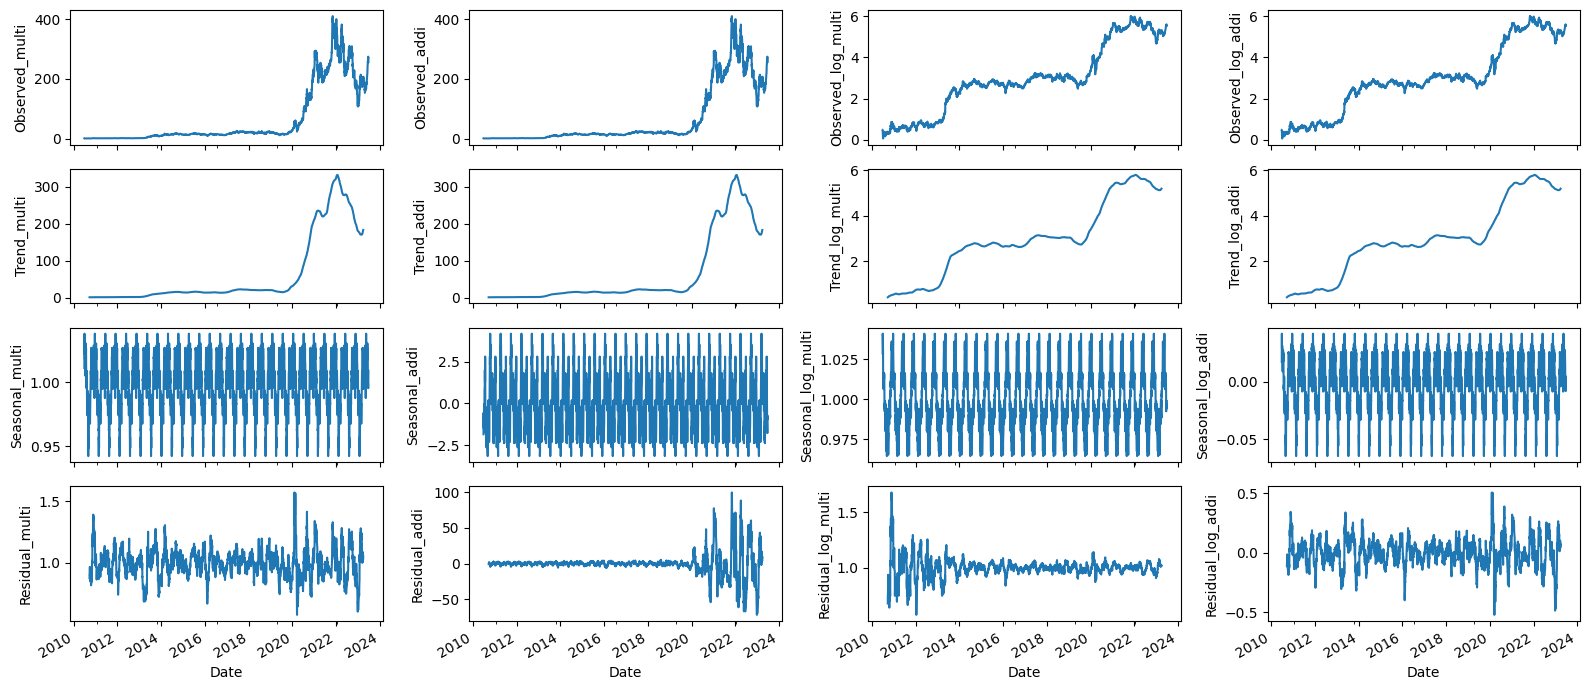

In [43]:
def plotdecompose(res, axes,title):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed'+ title)
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend'+ title)
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal'+ title)
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual'+ title)



stock_data.index = pd.to_datetime(stock_data.index)

result_muliplicative = seasonal_decompose((stock_data['Close']), model='multiplicative', period=120)
result_additive = seasonal_decompose((stock_data['Close']), model='additive', period=120)
result_muliplicative_log = seasonal_decompose(np.log(stock_data['Close']), model='multiplicative', period=120)
result_additive_log = seasonal_decompose(np.log(stock_data['Close']), model='additive', period=120)

fig, axes = plt.subplots(ncols=4, nrows=4, sharex=True, figsize=(16,7))

plotdecompose(result_muliplicative, axes[:,0],"_multi")
plotdecompose(result_additive, axes[:,1],"_addi")
plotdecompose(result_muliplicative_log, axes[:,2],"_log_multi")
plotdecompose(result_additive_log, axes[:,3],"_log_addi")

plt.tight_layout()
plt.show()


###Adfuller test to check if there is correlation###
> **Null hypothesis: The time series is not stationary**

> **Alternate hypothesis: The time series is stationtary**




In [47]:

result = adfuller(np.log(stock_data['Close'].dropna()),autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] <0.05:
  print("Reject NULL hypothesis")
else:
  print("Reject alternate hypothesis")

ADF Statistic: -0.537860
p-value: 0.884414
Reject alternate hypothesis


### Using pmdarima auto arima approach for time series data ###


> SARIMAX model selection based on the AIC value less is better

> PCF and PACF not required as the model will select various params using AIC



In [67]:
!pip install pmdarima

In [82]:
X_train = stock_data[:int(len(stock_data)*.9)]
y_test = stock_data[int(len(stock_data)*.9):]
print(X_train.head())
print(y_test.head())

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-03-07  285.433319  288.713318  268.190002  268.193329  268.193329   
2022-03-08  265.176666  283.329987  260.723328  274.799988  274.799988   
2022-03-09  279.826660  286.853333  277.336670  286.323334  286.323334   
2022-03-10  283.816681  284.816681  270.119995  279.433319  279.433319   
2022-03-11  280.066681  281.266663  264.58999

In [100]:
import pmdarima as pm


model = pm.auto_arima(X_train['Close'], start_p=1, start_q=1,
                      exogenous= X_train['Volume'],
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                     # m=80,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15971.693, Time=1.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15970.837, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15970.523, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15970.395, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15970.803, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15970.516, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15963.378, Time=2.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.76 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15965.117, Time=3.90 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=15970.964, Time=1.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15963.192, Time=1.54 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15970.330, Time=0.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15973.119, Time=0.75 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15971.118, Time=0.71 sec
 ARIMA(3,1,2)(0,0,0)[0] i

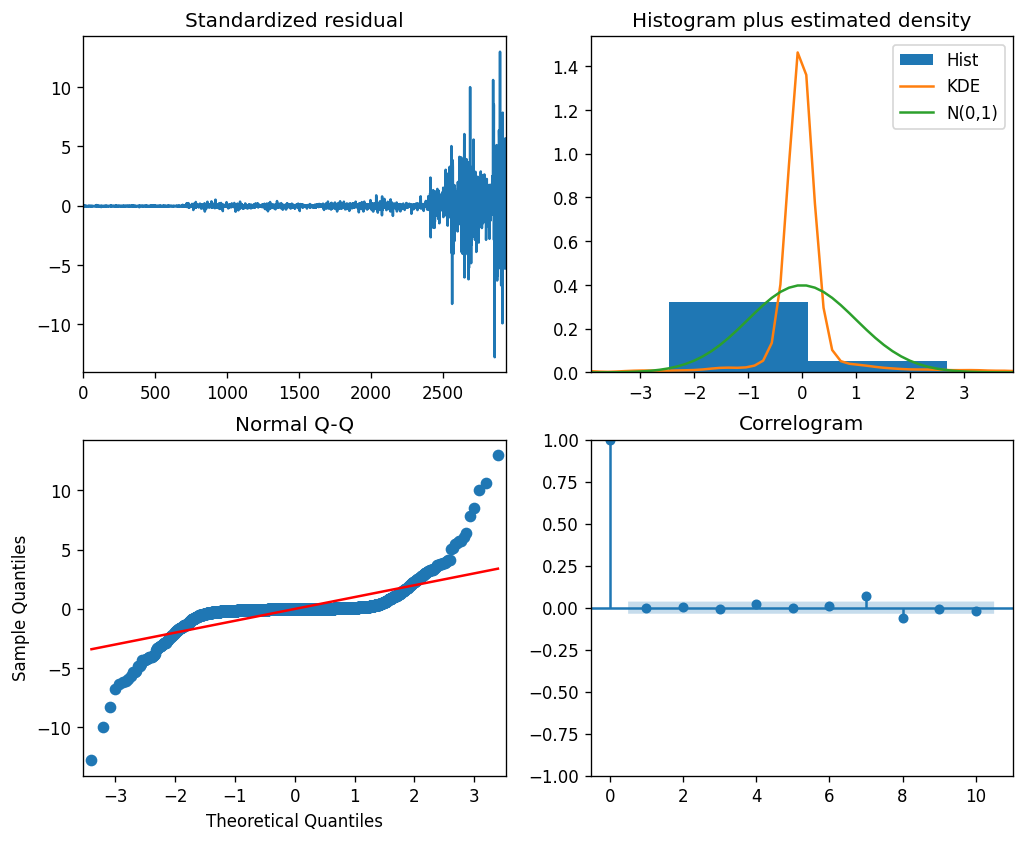

In [101]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

### Update model and fetch various model performance statistics ###

In [104]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with real data after related prediction
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(y_test['Close'], forecasts)}")
print(f"SMAPE: {smape(y_test['Close'], forecasts)}")
print(f"R2 SCORE: {r2_score(y_test['Close'], forecasts)}")

Mean squared error: 83.66134096581153
SMAPE: 3.0599473243049116
R2 SCORE: 0.9763298616506164


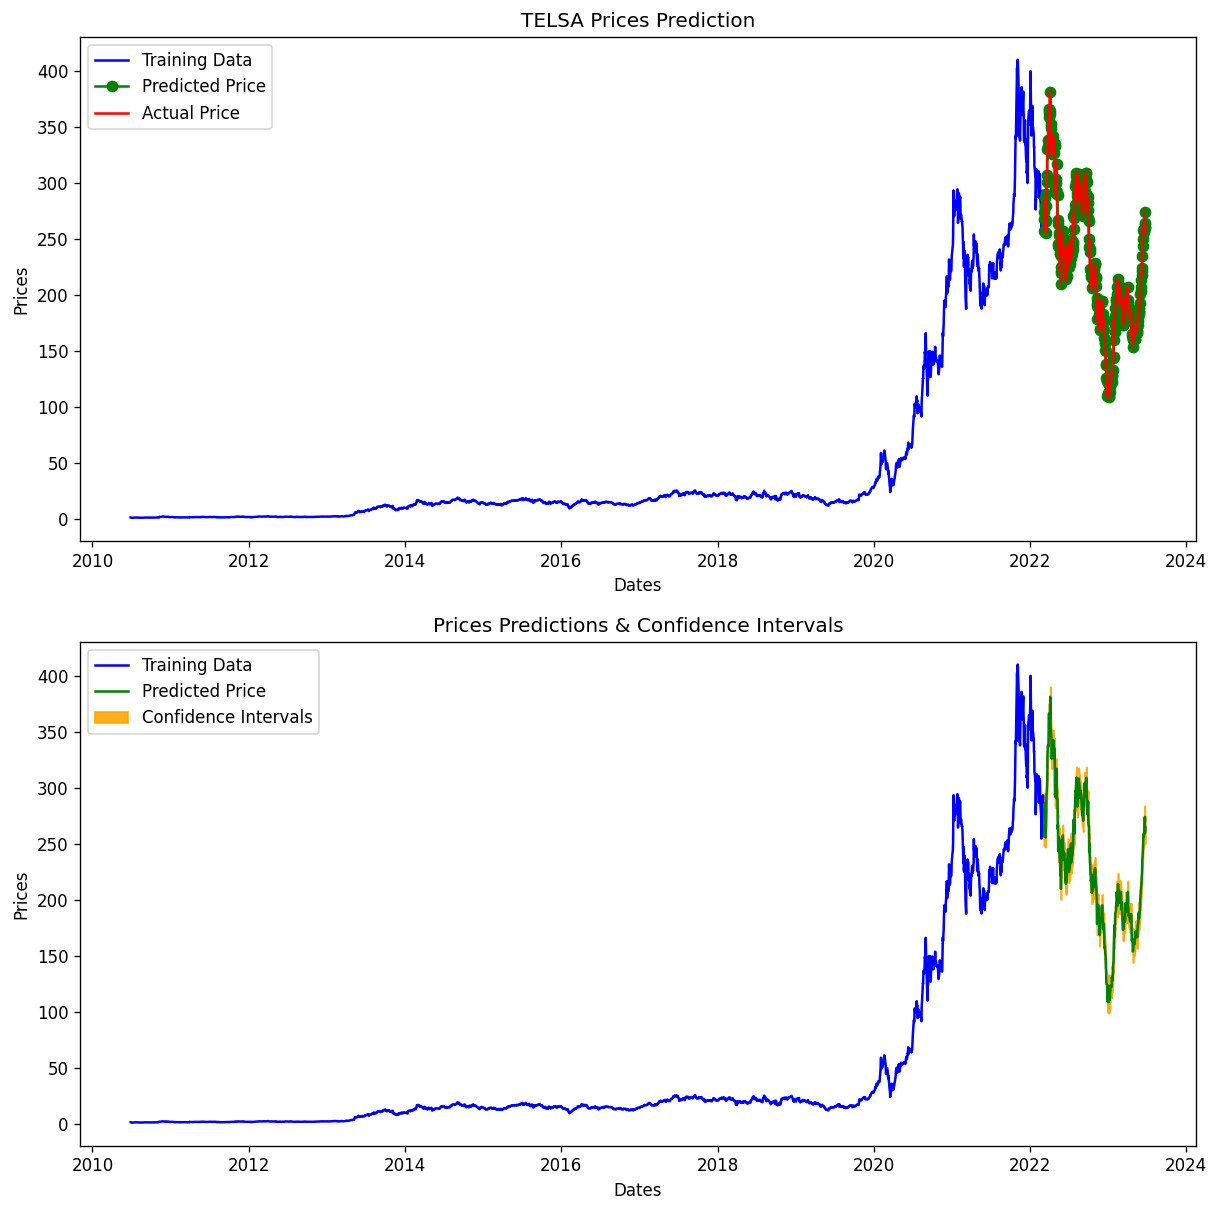

In [106]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(X_train['Close'], color='blue', label='Training Data')
axes[0].plot(y_test.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(y_test.index, y_test['Close'], color='red', label='Actual Price')
axes[0].set_title('TELSA Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

#axes[0].set_xticks(np.arange(0, len(X_train), len(y_test)).tolist(), stock_data.reset_index()['Date'][0:len(X_train), len(y_test)].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(X_train['Close'], color='blue', label='Training Data')
axes[1].plot(y_test.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(y_test.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

#axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), stock_data.reset_index()['Date'][0:7982:1300].tolist())
axes[1].legend()


# New Section

In [115]:
%%bash

cd sample_data
ls -lrt

total 55504
-rwxr-xr-x 1 root root      930 Jan  1  2000 README.md
-rwxr-xr-x 1 root root     1697 Jan  1  2000 anscombe.json
-rw-r--r-- 1 root root  1706430 Jun 29 13:30 california_housing_train.csv
-rw-r--r-- 1 root root   301141 Jun 29 13:30 california_housing_test.csv
-rw-r--r-- 1 root root 36523880 Jun 29 13:30 mnist_train_small.csv
-rw-r--r-- 1 root root 18289443 Jun 29 13:30 mnist_test.csv
